In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/phyto_curves_reco

/content/gdrive/My Drive/phyto_curves_reco


#Load functions

In [3]:
!pip install tensorflow-addons
!pip install fastparquet

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 2.6 MB/s 
     |████████████████████████████████| 59 kB 4.2 MB/s 
     |████████████████████████████████| 1.5 MB 11.0 MB/s 
     |████████████████████████████████| 125 kB 56.9 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348194 sha256=0cff0b56f55fe98868282c632d8586eab5befebfcaeb49c6bd516407477603f7
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift


In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import scipy.integrate as it
from collections import Counter

from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score

import tensorflow as tf
import os
import pickle
from collections import Counter
import pandas as pd
from keras.models import Model, load_model, model_from_json

from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from pred_functions import predict, combine_files_into_acquisitions, post_processing
from dataset_preprocessing import homogeneous_cluster_names, gen_train_test_valid
from losses import CB_loss, categorical_focal_loss


os.chdir('/content/gdrive/My Drive/data/SSLAMM')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Représentation des jeux de train, valid et test

In [ ]:
#importation data
dir = "/content/gdrive/MyDrive/data/SSLAMM/L2/Pulse/"

# Load the raw data
train = np.load(dir + 'train.npz', allow_pickle = True)
valid = np.load(dir + 'valid.npz', allow_pickle = True)
test = np.load(dir + 'test.npz', allow_pickle = True)
tn = pd.read_csv(dir + 'train_test_nomenclature.csv')

# Dispatch the data

X_test = test['X']
X_valid = valid['X']
X_train = train['X']
y_train = train['y']


In [ ]:
X_train.shape

(31236, 120, 5)

## Perform the prediction over the test set

In [9]:
# Load the model 
model = load_model('/content/gdrive/My Drive/Models/SSLAMM/cnn_HyperCateg41_9')
#model.load_weights('/content/gdrive/My Drive/Models/SSLAMM/weights_categorical_crossentropy_cnn_VGGBig.hdf5')

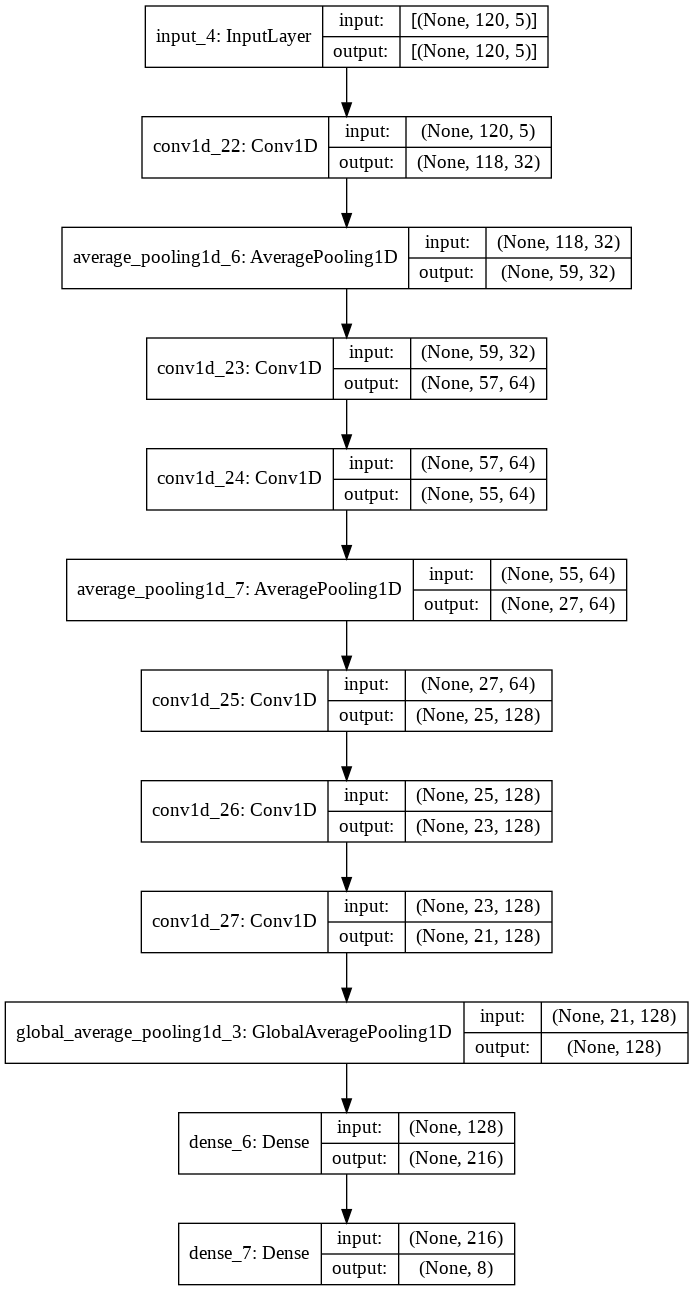

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_rawpred = model.predict(X_train)
valid_rawpred = model.predict(X_valid)
test_rawpred = model.predict(X_test)

train_preds = pd.Series(train_rawpred.argmax(1)).astype(str)
preds_proba_train = pd.Series(train_rawpred.max(1)).astype(str)

valid_preds = pd.Series(valid_rawpred.argmax(1)).astype(str)
preds_proba_valid = pd.Series(valid_rawpred.max(1)).astype(str)

test_preds = pd.Series(test_rawpred.argmax(1)).astype(str)
preds_proba_test = pd.Series(test_rawpred.max(1)).astype(str)

In [ ]:
del(train_rawpred)
del(valid_rawpred)
del(test_rawpred)

### Format consensual particles train / valid / test sets

In [ ]:
# Compute the integrals for both sets 
train_it = pd.DataFrame(data = it.trapz(train['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])
valid_it = pd.DataFrame(data = it.trapz(valid['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])
test_it = pd.DataFrame(data = it.trapz(test['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])

# Store the consensual class
y_train = pd.Series(train['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)
y_valid = pd.Series(valid['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)
y_test = pd.Series(test['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)

# Turn numbers into class labels
for idx, row in tn.iterrows():
  y_train = y_train.str.replace(str(row['id']), row['name'])
  y_valid = y_valid.str.replace(str(row['id']), row['name'])
  y_test = y_test.str.replace(str(row['id']), row['name'])

  train_preds = train_preds.str.replace(str(row['id']), row['name'])
  valid_preds = valid_preds.str.replace(str(row['id']), row['name'])
  test_preds =  test_preds.str.replace(str(row['id']), row['name'])

# Add them as a column 
train_it['True FFT Label'] = y_train
train_it['Pred FFT Label'] = train_preds
train_it['Niveau confiance'] = preds_proba_train

valid_it['True FFT Label'] = y_valid
valid_it['Pred FFT Label'] = valid_preds
valid_it['Niveau confiance'] = preds_proba_valid

test_it['True FFT Label'] = y_test
test_it['Pred FFT Label'] = test_preds
test_it['Niveau confiance'] = preds_proba_test

In [ ]:
del(train)
del(valid)
del(test)

## Display the performance

In [ ]:
set_ = valid_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9789618662305243
Classes accuracy:  {'MICRO': 0.8672199170124482, 'ORGNANO': 0.8168316831683168, 'ORGPICOPRO': 0.9975879891705636, 'REDNANO': 0.9571258435887257, 'REDPICOEUK': 0.9837176264889084, 'REDPICOPRO': 0.6733909702209414, 'inf1microm': 0.9975161188035091, 'sup1microm': 0.9192132068844397}
Macro accuracy:  0.9015754194172315


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         209        0           0        0           0           0   
ORGNANO         0      165           0        0           0           0   
ORGPICOPRO      0        0       20266        0           0          61   
REDNANO        29       13           0     2411          13           1   
REDPICOEUK      0        0           1       77        9002           4   
REDPICOPRO      0        0           0        0           0         701   
inf1micr

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9736230878073524
Classes accuracy:  {'MICRO': 0.3310344827586207, 'ORGNANO': 0.8537549407114624, 'ORGPICOPRO': 0.997952661539998, 'REDNANO': 0.9570803331921502, 'REDPICOEUK': 0.9837413852187488, 'REDPICOPRO': 0.10393700787401575, 'inf1microm': 0.9922865013774105, 'sup1microm': 0.8920839254367634}
Macro accuracy:  0.7639839047636463


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO          48        0           0        1           0           0   
ORGNANO         0      648           0        0           0           0   
ORGPICOPRO      0        0       59955        0           0         340   
REDNANO        93       45           0     6779           6           0   
REDPICOEUK      0        0           0      232       25836          17   
REDPICOPRO      0        0           0        0           0          66   
inf1micr

### Misclassification visualisation

In [ ]:
colors = {'ORGPICOPRO' : 'darkorange', 'REDPICOEUK': 'tomato', 'REDNANO': 'maroon', 'REDPICOPRO': 'red',\
          'REDMICRO' : 'darkblue', 'inf1microm': 'chocolate', 'sup1microm': 'peachpuff', 'ORGMICRO': 'gold',\
          'inf1microm_particle' : 'chocolate', 'sup1microm_particle': 'aquamarine',\
          'Non-consensual' : 'black', 'ORGNANO': 'chartreuse', 'MICRO' : 'mediumblue',\
          'Unassigned Particles' : 'lightgreen'}

# The quantities to plot
q1 = 'Total FWS'
q2 = 'Total FLR'
q3 = 'Total FLO'

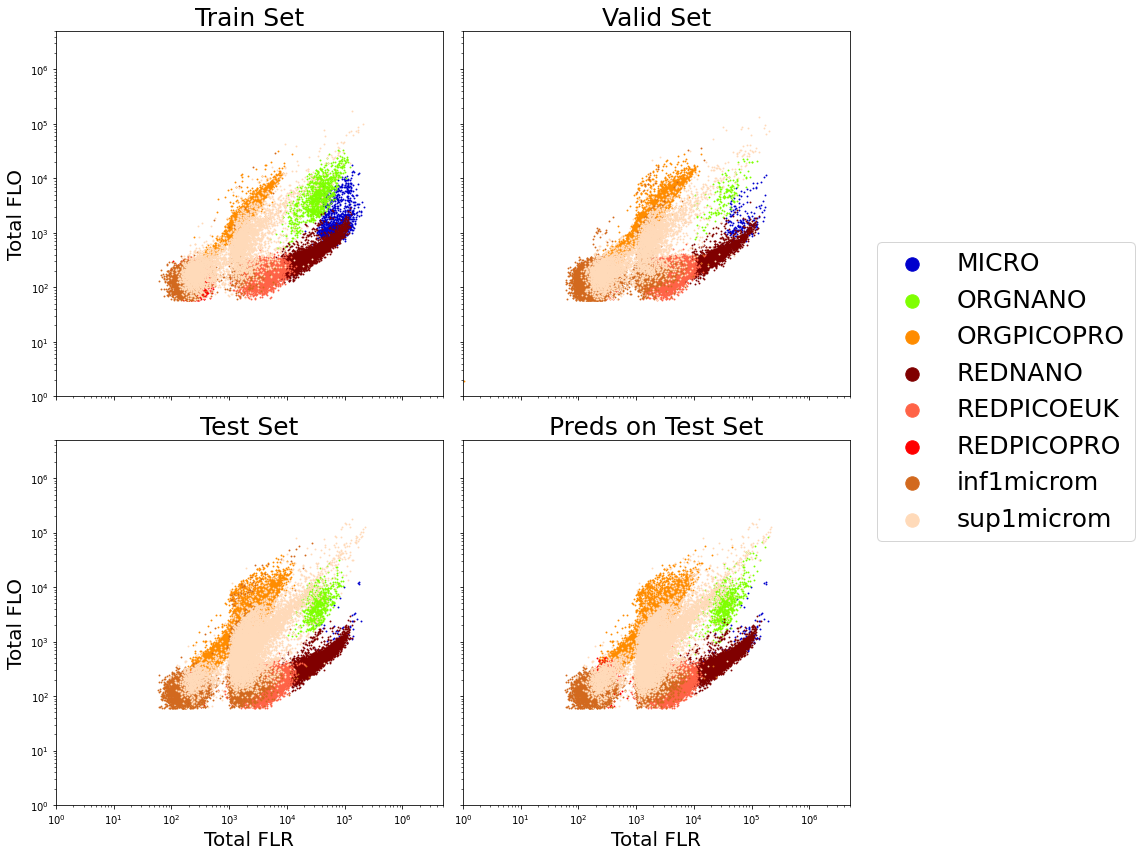

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 12))

# Train set
for idx, row in tn.iterrows():
  obs = train_it[train_it['True FFT Label'] == row['name']]
  axs[0,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Valid set
for idx, row in tn.iterrows():
  obs = valid_it[valid_it['True FFT Label'] == row['name']]
  axs[0,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['True FFT Label'] == row['name']]
  axs[1,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Preds on test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['Pred FFT Label'] == row['name']]
  axs[1,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Handling the titles
axs[0,0].set_title('Train Set', fontsize = 25)
axs[0,1].set_title('Valid Set', fontsize = 25)
axs[1,0].set_title('Test Set', fontsize = 25)
axs[1,1].set_title('Preds on Test Set', fontsize = 25)

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(q1, fontsize = 20)
    ax.set_ylabel(q2, fontsize = 20)
    ax.set_xlim (1,5*10**6)
    ax.set_ylim (1,5*10**6)

    ax.label_outer()


fig.legend(tn['name'], markerscale = 15, bbox_to_anchor=(1,0.35), loc="lower left", fontsize = 25)
fig.tight_layout()
fig.show()

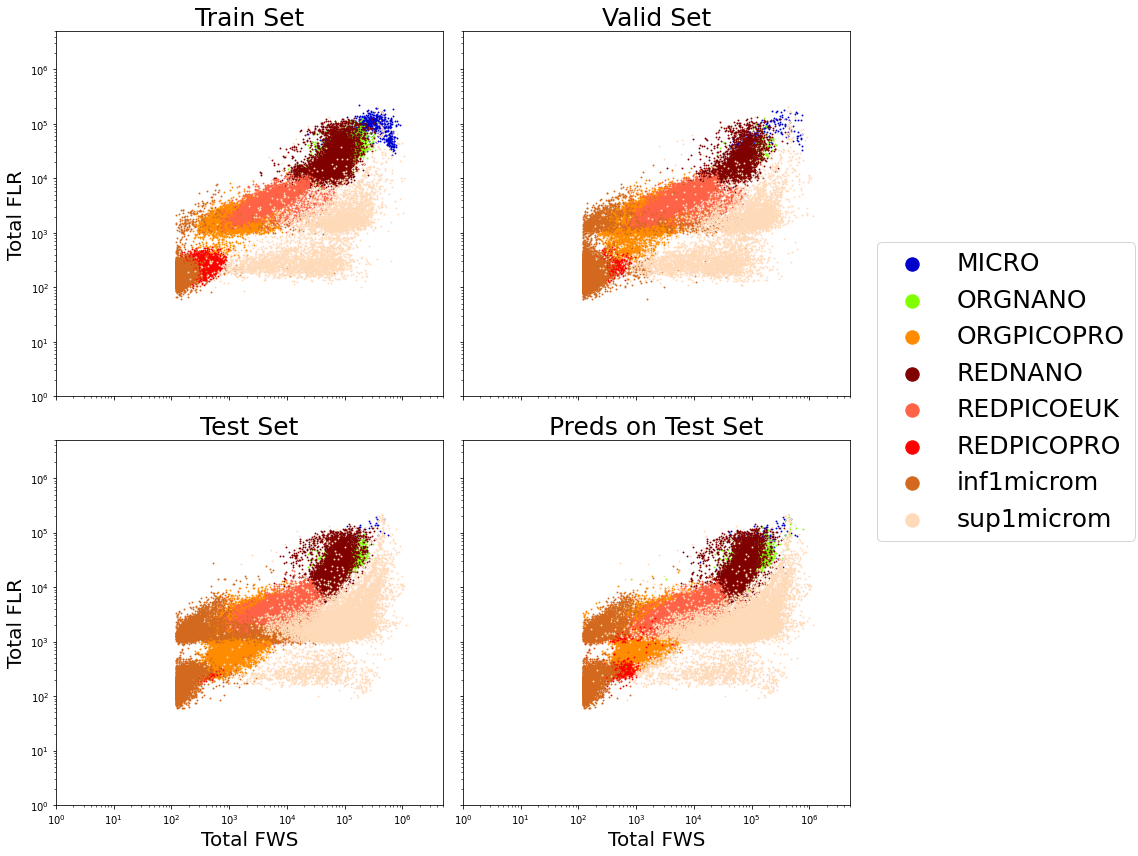

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 12))

# Train set
for idx, row in tn.iterrows():
  obs = train_it[train_it['True FFT Label'] == row['name']]
  axs[0,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Valid set
for idx, row in tn.iterrows():
  obs = valid_it[valid_it['True FFT Label'] == row['name']]
  axs[0,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['True FFT Label'] == row['name']]
  axs[1,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Preds on test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['Pred FFT Label'] == row['name']]
  axs[1,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Handling the titles
axs[0,0].set_title('Train Set', fontsize = 25)
axs[0,1].set_title('Valid Set', fontsize = 25)
axs[1,0].set_title('Test Set', fontsize = 25)
axs[1,1].set_title('Preds on Test Set', fontsize = 25)

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(q1, fontsize = 20)
    ax.set_ylabel(q2, fontsize = 20)
    ax.set_xlim (1,5*10**6)
    ax.set_ylim (1,5*10**6)
    ax.label_outer()


fig.legend(tn['name'], markerscale = 15, bbox_to_anchor=(1,0.35), loc="lower left", fontsize = 25)
fig.tight_layout()
fig.show()

# Prediction confidence visualisation 

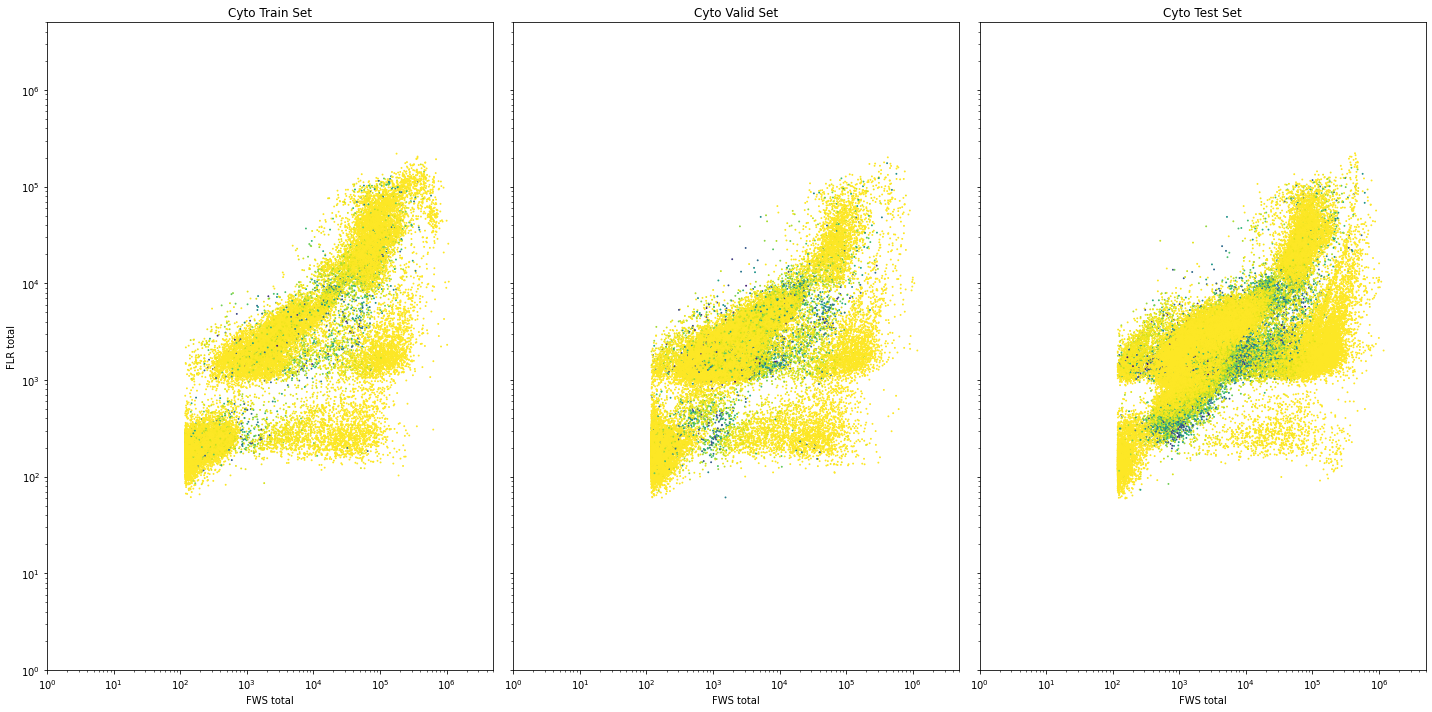

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

train_x = np.array(train_it['Total FWS'])
train_y = np.array(train_it['Total FLR'])
train_z = np.array(train_it['Niveau confiance'])

valid_x = np.array(valid_it['Total FWS'])
valid_y = np.array(valid_it['Total FLR'])
valid_z = np.array(valid_it['Niveau confiance'])


test_x = np.array(test_it['Total FWS'])
test_y = np.array(test_it['Total FLR'])
test_z = np.array(test_it['Niveau confiance'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.set_ylim (1,5*10**6)

    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
#plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SSLAMM/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

# Plot misclassified points

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
train_it['Mispredicted'] = train_it['Pred FFT Label'] != train_it['True FFT Label']
valid_it['Mispredicted'] = valid_it['Pred FFT Label'] != valid_it['True FFT Label']
test_it['Mispredicted'] = test_it['Pred FFT Label'] != test_it['True FFT Label']

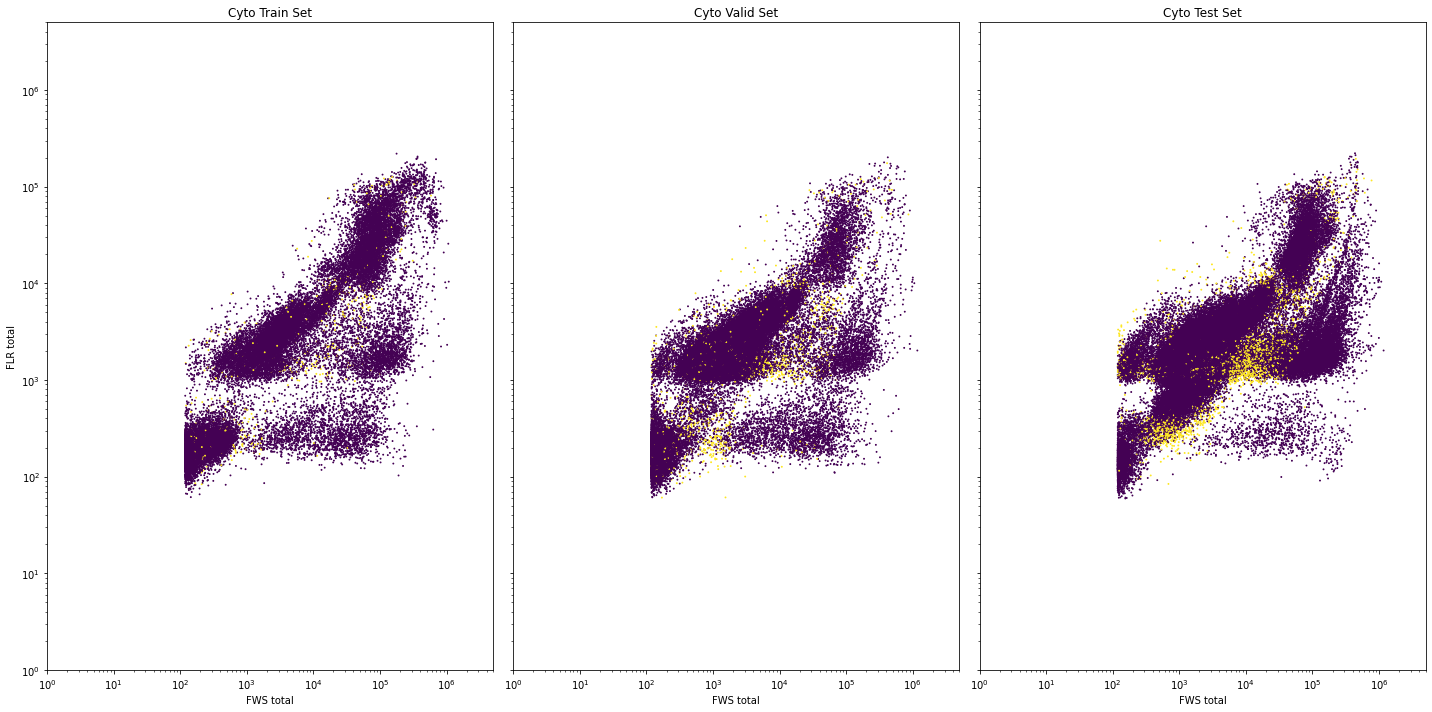

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

#train_x = np.array(train_it['Total FWS'])
#train_y = np.array(train_it['Total FLR'])
train_z = np.array(train_it['Mispredicted'])

#valid_x = np.array(valid_it['Total FWS'])
#valid_y = np.array(valid_it['Total FLR'])
valid_z = np.array(valid_it['Mispredicted'])


#test_x = np.array(test_it['Total FWS'])
#test_y = np.array(test_it['Total FLR'])
test_z = np.array(test_it['Mispredicted'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.set_ylim (1,5*10**6)

    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
#plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SSLAMM/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

# Influence of the confidence level over the precision

In [ ]:
from copy import deepcopy
set_ = deepcopy(train_it)
X_set = deepcopy(train['X'])
set_['Niveau confiance'] = set_['Niveau confiance'].astype(float)

all_classes = set(set_['True FFT Label'])
class_ = 'REDPICOPRO'
other_classes = all_classes - set([class_])

0
{'MICRO': 0.33, 'ORGNANO': 0.85, 'ORGPICOPRO': 1.0, 'REDNANO': 0.96, 'REDPICOEUK': 0.98, 'REDPICOPRO': 0.1, 'inf1microm': 0.99, 'sup1microm': 0.89}
Share of the dataset kept 1.0
--------------------------
0.5
{'MICRO': 0.34, 'ORGNANO': 0.86, 'ORGPICOPRO': 1.0, 'REDNANO': 0.96, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.12, 'inf1microm': 0.99, 'sup1microm': 0.9}
Share of the dataset kept 0.9962000872111132
--------------------------
0.7
{'MICRO': 0.43, 'ORGNANO': 0.91, 'ORGPICOPRO': 1.0, 'REDNANO': 0.97, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.15, 'inf1microm': 1.0, 'sup1microm': 0.93}
Share of the dataset kept 0.9820060335851777
--------------------------
0.8
{'MICRO': 0.5, 'ORGNANO': 0.92, 'ORGPICOPRO': 1.0, 'REDNANO': 0.98, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.18, 'inf1microm': 1.0, 'sup1microm': 0.95}
Share of the dataset kept 0.971700883679953
--------------------------
0.85
{'MICRO': 0.53, 'ORGNANO': 0.93, 'ORGPICOPRO': 1.0, 'REDNANO': 0.98, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.2, 'inf1micro

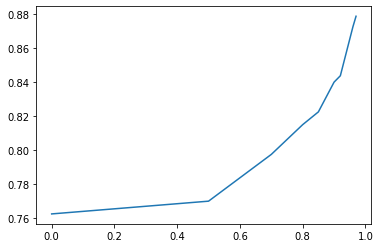

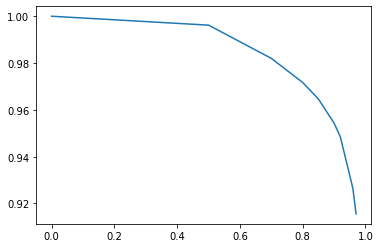

In [ ]:
perf = pd.DataFrame()

for thr in [0, 0.5, 0.70, 0.8, 0.85, 0.9, 0.92, 0.96, 0.97]:
  print(thr)
  purified_set = set_[set_['Niveau confiance'] >= thr]
  class_accuracy = precision_score(purified_set['True FFT Label'], purified_set['Pred FFT Label'], average = None)
  class_accuracy = [round(cc, 2) for cc in class_accuracy]
  print(dict(zip(tn['name'], class_accuracy)))
  print('Share of the dataset kept', len(purified_set) / len(set_))
  print('--------------------------')
  perf = perf.append({'thr': thr, 'class_accuracy': np.mean(class_accuracy), 'share kept': len(purified_set) / len(set_)}, ignore_index = True)

plt.plot(perf['thr'], perf['class_accuracy'])
plt.show()
plt.plot(perf['thr'], perf['share kept'])
plt.show()

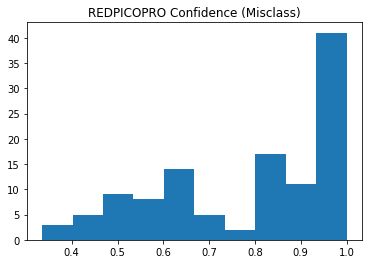

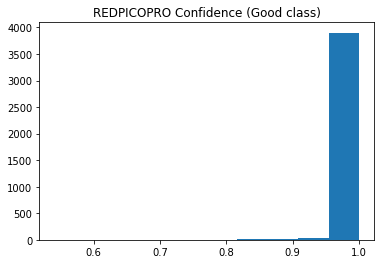

True FFT Label
ORGPICOPRO    0.835593
REDPICOEUK    0.488919
inf1microm    0.905752
sup1microm    0.629012
Name: Niveau confiance, dtype: float64


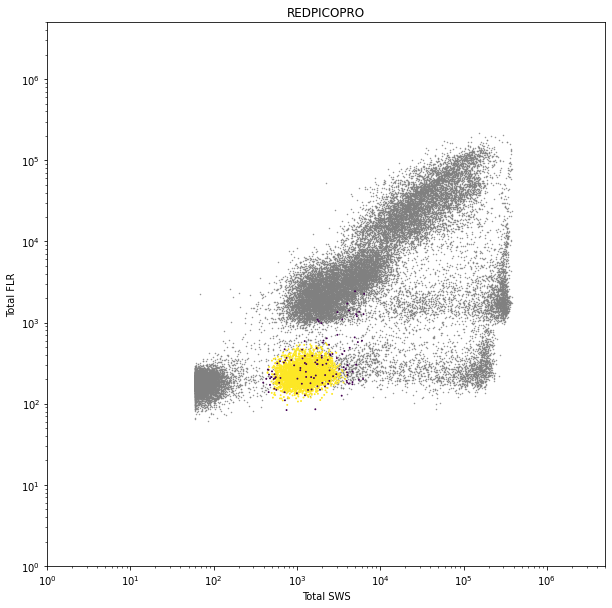

In [ ]:
q1 = 'Total SWS'
q1_curves = 1
q2 = 'Total FLR'
q2_curves = 3
q3 = 'Total FWS'
q3_curves = 0

#misclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'].isin(other_classes))]
misclass = set_[(set_['True FFT Label'].isin(other_classes)) & (set_['Pred FFT Label'] == class_ )]
goodclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'] == class_)]

plt.hist(misclass['Niveau confiance'].to_list())
plt.title(class_ + ' Confidence (Misclass)')
plt.show()
plt.title(class_ + ' Confidence (Good class)')
plt.hist(goodclass['Niveau confiance'].to_list())
plt.show()

# Confidence level when fail
print(misclass[['True FFT Label', 'Niveau confiance']].groupby(['True FFT Label'])['Niveau confiance'].median())

# Location in the plot
goodclass['right pred'] = 1
misclass['right pred'] = 0
allclass = goodclass.append(misclass)
otherclasses_idx = set(set_.index) - set(allclass.index)
otherclasses = set_.loc[otherclasses_idx]

plt.scatter(otherclasses[q1], otherclasses[q2], c = 'grey',  s = 0.2)
plt.scatter(allclass[q1], allclass[q2], c = allclass['right pred'],  s = 0.8, cmap = cm.viridis)
#plt.scatter(misclass[q1], misclass[q2], c = 'violet',  s = 0.8, cmap = cm.viridis)
#plt.scatter(goodclass[q1], goodclass[q2], c = 'yellow',  s = 0.8, cmap = cm.viridis)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(q1)
plt.ylabel(q2)
plt.title(class_)
plt.xlim(1,5*10**6)
plt.ylim(1,5*10**6)

fig = plt.gcf()
fig.set_size_inches(10, 10)

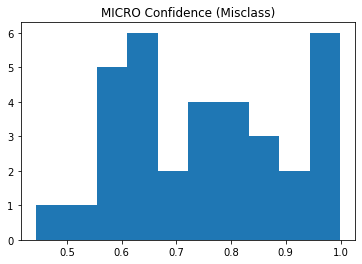

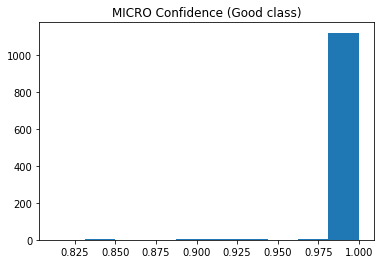

True FFT Label
REDNANO       0.734531
sup1microm    0.684559
Name: Niveau confiance, dtype: float64


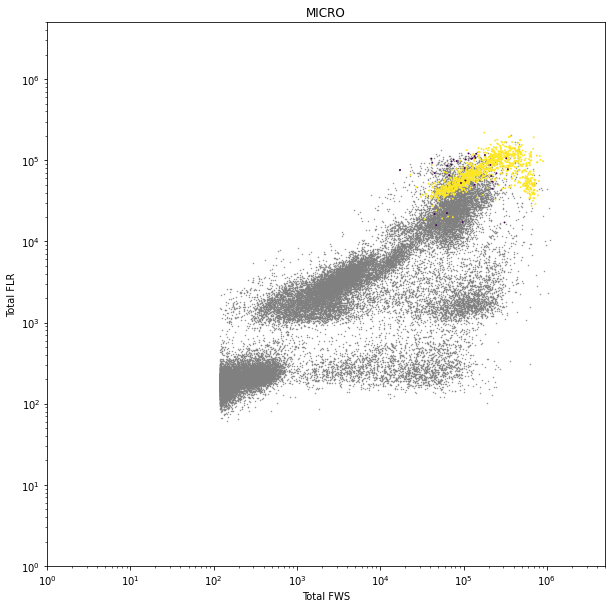

In [ ]:
all_classes = set(set_['True FFT Label'])
class_ = 'MICRO'
other_classes = all_classes - set([class_])

set_['Niveau confiance'] = set_['Niveau confiance'].astype(float)
q1 = 'Total FWS'
q1_curves = 0
q2 = 'Total FLR'
q2_curves = 3
q3 = 'Total FLO'
q3_curves = 2

#misclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'].isin(other_classes))]
misclass = set_[(set_['True FFT Label'].isin(other_classes)) & (set_['Pred FFT Label'] == class_ )]
goodclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'] == class_)]

plt.hist(misclass['Niveau confiance'].to_list())
plt.title(class_ + ' Confidence (Misclass)')
plt.show()
plt.title(class_ + ' Confidence (Good class)')
plt.hist(goodclass['Niveau confiance'].to_list())
plt.show()

# Confidence level when fail
print(misclass[['True FFT Label', 'Niveau confiance']].groupby(['True FFT Label'])['Niveau confiance'].median())

# Location in the plot
goodclass['right pred'] = 1
misclass['right pred'] = 0
allclass = goodclass.append(misclass)
otherclasses_idx = set(set_.index) - set(allclass.index)
otherclasses = set_.loc[otherclasses_idx]

plt.scatter(otherclasses[q1], otherclasses[q2], c = 'grey',  s = 0.2)
plt.scatter(allclass[q1], allclass[q2], c = allclass['right pred'],  s = 0.8, cmap = cm.viridis)
#plt.scatter(misclass[q1], misclass[q2], c = 'violet',  s = 0.8, cmap = cm.viridis)
#plt.scatter(goodclass[q1], goodclass[q2], c = 'yellow',  s = 0.8, cmap = cm.viridis)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(q1)
plt.ylabel(q2)
plt.title(class_)
plt.xlim(1,5*10**6)
plt.ylim(1,5*10**6)

fig = plt.gcf()
fig.set_size_inches(10, 10)

# Plot outliers curves

In [ ]:
from scipy.stats import shapiro 

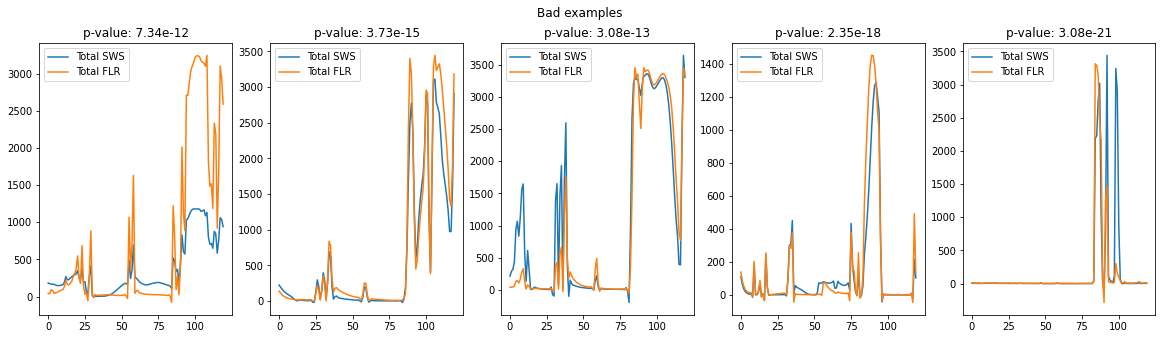

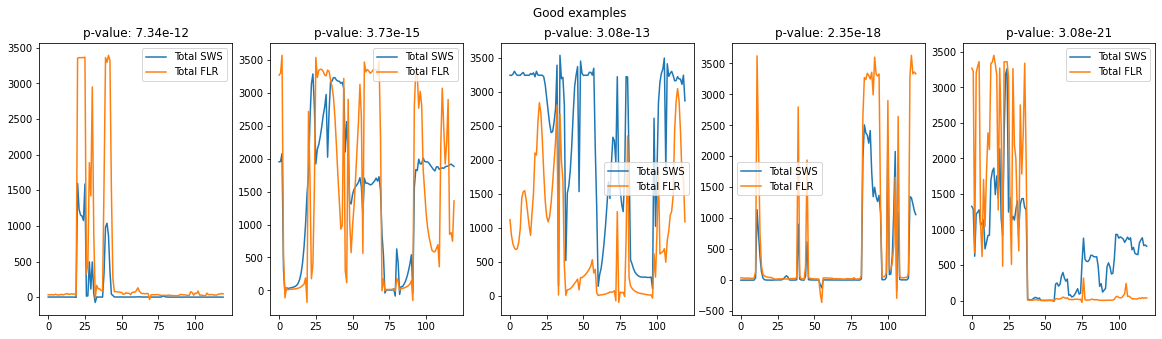

In [ ]:
nb_examples = 5

bad_examples_idx = misclass.sample(n = nb_examples).index
good_examples = goodclass.sample(n = nb_examples).index

# Fetch the curves
bad_examples = X_set[bad_examples_idx]
good_examples = X_set[good_examples]

fig, axs = plt.subplots(1, nb_examples, figsize = (20, 5), sharex = True)

for i in range(nb_examples):
  axs[i].plot(bad_examples[i,:,q1_curves], label = q1)
  axs[i].plot(bad_examples[i,:,q2_curves], label = q2)
  axs[i].set_title('p-value: ' + str("{:.2e}".format(shapiro(bad_examples[i,:,q1_curves])[1], 6)))
  axs[i].legend([q1, q2])

fig.suptitle('Bad examples')
plt.show()

fig, axs = plt.subplots(1, nb_examples, figsize = (20, 5), sharex = True)

for i in range(nb_examples):
  axs[i].plot(good_examples[i,:,q1_curves], label = q1)
  axs[i].plot(good_examples[i,:,q2_curves], label = q2)
  axs[i].legend([q1, q2])
  axs[i].set_title('p-value: ' + str("{:.2e}".format(shapiro(bad_examples[i,:,q1_curves])[1], 6)))
fig.suptitle('Good examples')
plt.show()

In [ ]:
def shapTest(x):
  x_pos = np.where(x <= 0, 1E-16, x)
  p = x_pos / x_pos.sum()
  draws = np.random.choice(a = range(len(x)), size = len(x_pos), p = p)
  return shapiro(draws)[1]

In [ ]:
set_SWS = X_set[:,:,1]
np.random.seed(seed=0)
shap = np.apply_along_axis(shapTest, 1, set_SWS)

2859


(array([1.08856e+05, 1.09700e+03, 4.94000e+02, 3.51000e+02, 2.65000e+02,
        1.82000e+02, 1.43000e+02, 1.13000e+02, 1.04000e+02, 7.10000e+01,
        7.30000e+01, 8.00000e+01, 7.50000e+01, 5.60000e+01, 5.30000e+01,
        3.80000e+01, 3.80000e+01, 3.20000e+01, 3.10000e+01, 3.10000e+01,
        2.70000e+01, 2.20000e+01, 3.10000e+01, 2.50000e+01, 2.50000e+01,
        1.20000e+01, 1.70000e+01, 8.00000e+00, 1.30000e+01, 8.00000e+00]),
 array([1.77534467e-21, 3.33333333e-02, 6.66666667e-02, 1.00000000e-01,
        1.33333333e-01, 1.66666667e-01, 2.00000000e-01, 2.33333333e-01,
        2.66666667e-01, 3.00000000e-01, 3.33333333e-01, 3.66666667e-01,
        4.00000000e-01, 4.33333333e-01, 4.66666667e-01, 5.00000000e-01,
        5.33333333e-01, 5.66666667e-01, 6.00000000e-01, 6.33333333e-01,
        6.66666667e-01, 7.00000000e-01, 7.33333333e-01, 7.66666667e-01,
        8.00000000e-01, 8.33333333e-01, 8.66666667e-01, 9.00000000e-01,
        9.33333333e-01, 9.66666667e-01, 1.00000000e+00])

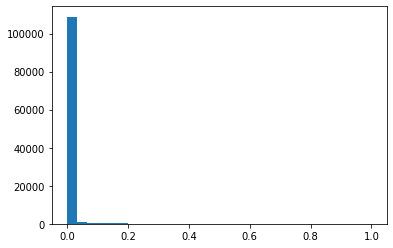

In [ ]:
good_idx = np.where(shap >= 0.05)[0]
shap_good = shap[good_idx]
print(len(good_idx))
plt.hist(shap, bins = 30)

In [ ]:
from scipy.signal import find_peaks
prominence = 3.0
def onepeak(x):
  peaks_id, _  = find_peaks(x, prominence = prominence)
  drops_id, _  = find_peaks(-x, prominence = prominence + 3.0)

  return (len(peaks_id) == 1) & (len(drops_id) <= 1)

onepeaked = np.apply_along_axis(onepeak, 1, set_SWS)

In [ ]:
op_good_idx = np.where(onepeaked)[0]
op_good = onepeaked[op_good_idx]

In [ ]:
print(len(op_good_idx))
print(len(shap) - len(good_idx))

3447
109512


In [ ]:
indices = np.random.choice(op_good_idx, size = 5)

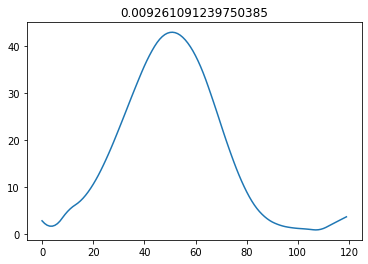

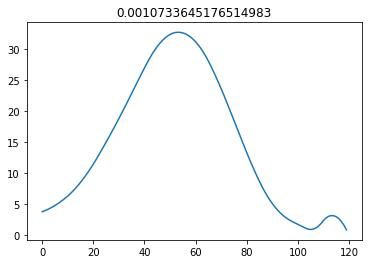

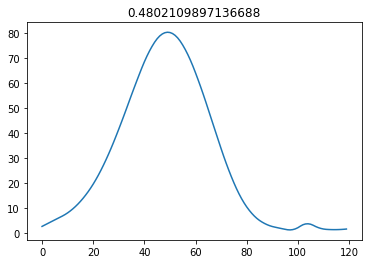

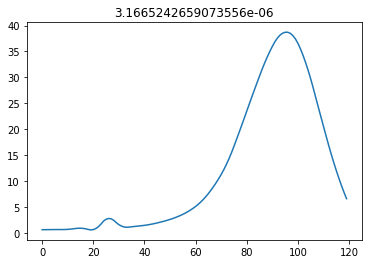

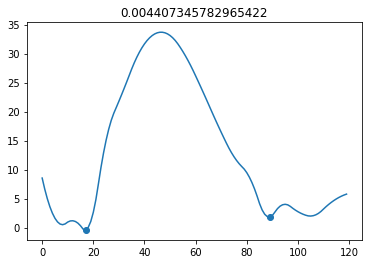

In [ ]:
indices = np.random.choice(op_good_idx, size = 5)

for i in indices:
  plt.plot(set_SWS[i])
  peaks_id, _  = find_peaks(-set_SWS[i], prominence = prominence)
  plt.scatter(peaks_id, set_SWS[i][peaks_id])
  plt.title(shap[i])
  plt.show()

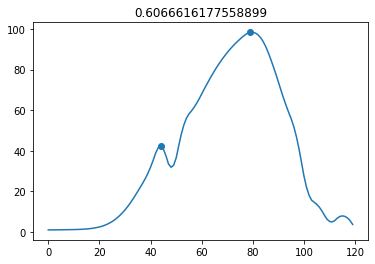

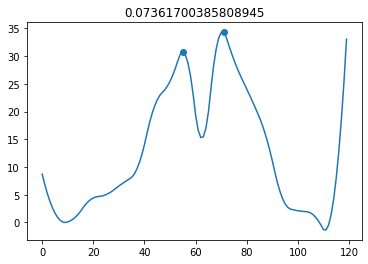

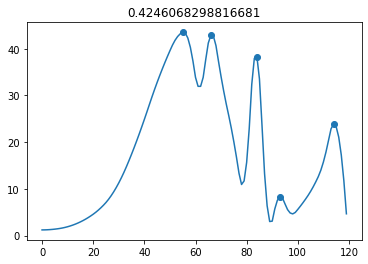

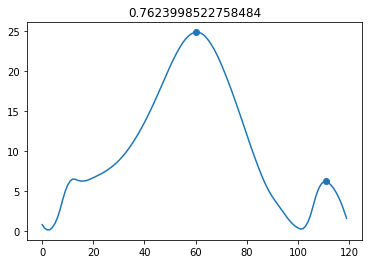

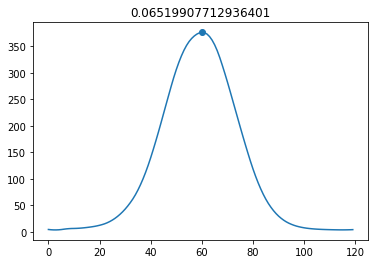

In [ ]:
indices = np.random.choice(good_idx, size = 5)
for i in indices:
  plt.plot(set_SWS[i])
  peaks_id, _  = find_peaks(set_SWS[i], prominence = 3.0)
  plt.scatter(peaks_id, set_SWS[i][peaks_id])
  plt.title(shap[i])
  plt.show()

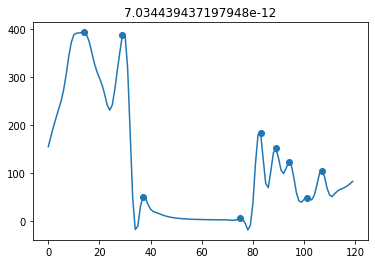

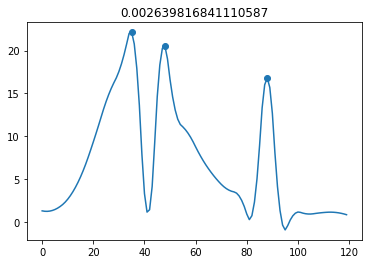

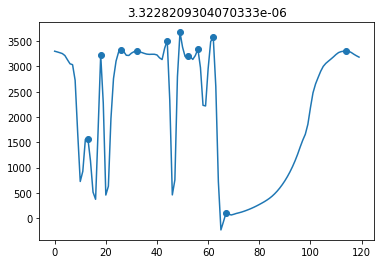

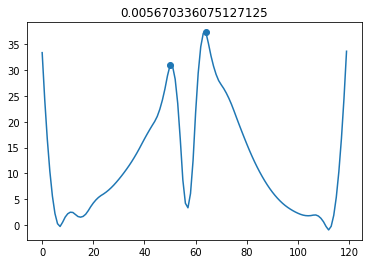

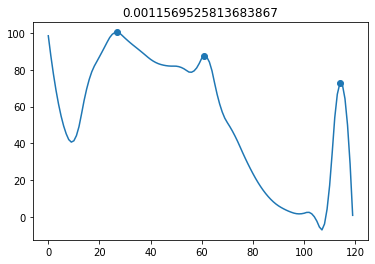

In [ ]:
indices = np.random.choice(list(set(range(len(shap))) - set(op_good_idx)), size = 5)
for i in indices:
  plt.plot(set_SWS[i])
  peaks_id, _  = find_peaks(set_SWS[i], prominence = 3.0)
  plt.scatter(peaks_id, set_SWS[i][peaks_id])
  plt.title(shap[i])
  plt.show()

In [ ]:
shap.max()

0.9998610615730286

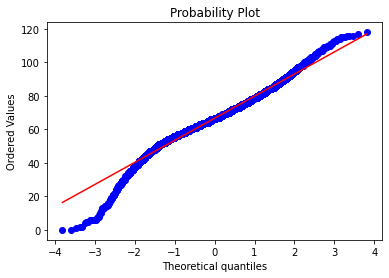

In [ ]:
import scipy.stats as stats
import pylab 
measurements = np.random.normal(loc = draws.mean(), scale = draws.std(), size=10000)   
stats.probplot(draws, dist="norm", plot=pylab)
pylab.show()